In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from discoutils.thesaurus_loader import Vectors as vv
from joblib import Parallel, delayed
from thesisgenerator.composers.vectorstore import AdditiveComposer, RightmostWordComposer, LeftmostWordComposer, MultiplicativeComposer
from collections import defaultdict
from scipy.spatial.distance import euclidean

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def _turney2010(allow_overlap=True):
    df = pd.read_csv('../thesisgenerator/similarity-data/turney-2012-jair-phrasal.txt',
                       names=['phrase'] + ['word%d'% i for i in range(1, 7)], 
                       comment='#', sep='|', index_col=0)
    for col in df.columns:
        df[col] = list(map(str.strip, df[col].values))
    df.index = list(map(str.strip, df.index))
    return df if allow_overlap else df.drop(['word1', 'word2'], axis=1)

ALLOW_OVERLAP = False
df = _turney2010(ALLOW_OVERLAP)
if ALLOW_OVERLAP:
    assert list(df.values[0, :]) == ['binary', 'double', 'star', 'dual', 'lumen', 'neutralism', 'keratoplasty']
else:
    assert list(df.values[0, :]) == ['binary', 'dual', 'lumen', 'neutralism', 'keratoplasty']
df.head()#.drop(['word2', 'word3'], axis=1)

,phrase,word3,word4,word5,word6
double star,binary,dual,lumen,neutralism,keratoplasty
bass fiddle,contrabass,pitch,violin,speedway,snood
saber saw,jigsaw,sabre,proverb,stockpiling,moonlighter
premature baby,preemie,babe,ponce,pyuria,expose
computer keyboard,keypad,machine,device,vestal,nihilism


In [3]:
def _add_tags(phrase):
    words = phrase.split()
    for pos in 'JN':
        yield '{1}/{0}_{2}/N'.format(pos, *words)

def _add_pos(word):
    for pos in 'NJ':
        yield '{}/{}'.format(word, pos)
        
print(list(_add_tags('double star')))
print(list(_add_pos('double')))

['double/J_star/N', 'double/N_star/N']
['double/N', 'double/J']


In [4]:
def _maxint():
    return 1e19

def predict(phrase, words, composer, unigram_source):
    sims = defaultdict(_maxint)
    for candidate_phrase in _add_tags(phrase):
        if candidate_phrase in composer and composer.get_vector(candidate_phrase) is not None:
            phrase_vector = composer.get_vector(candidate_phrase).A
            for wordid, word in enumerate(words):
                for candidate_word in _add_pos(word):
                    if candidate_word in unigram_source:
                        word_vector = unigram_source.get_vector(candidate_word).A
                        distance = euclidean(phrase_vector.ravel(), word_vector.ravel())
                        if distance < sims[word]:
                            sims[word] = distance
                if wordid == 0 and sims[word] > 1e10:
                    # don't have a word vector for the gold std neighbour
                    return None, None
    if not sims:
#         print('cant process', phrase)
        return None, None
    else:
        return min(sims, key=sims.get), sims

def evaluate(path, composer_class):
    unigram_source = vv.from_tsv(path)
    composer = composer_class(unigram_source)
    
    attempted, correct = 0, 0
    for phrase, words in df.iterrows():
        most_similar, _ = predict(phrase, words, composer, unigram_source)
        if most_similar:
            attempted += 1
#             print('phrase: %s, gold: %s, pred: %s' %(phrase, words[0], most_similar))
            if most_similar == words[0]:
                correct += 1
    coverage = attempted/len(df)
    accuracy = correct/attempted
    return coverage, accuracy, composer.name

In [5]:
paths = ['../FeatureExtractionToolkit/word2vec_vectors/word2vec-gigaw-100perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-50perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep0'
        ]
names = ['w2v-giga-100', 'w2v-wiki-15', 
         'w2v-wiki-50', 'w2v-wiki-100'
        ]
composers = [AdditiveComposer, MultiplicativeComposer, RightmostWordComposer] 
# right/left should always score 0 with overlap

results = []
for path, vname in zip(paths, names):
    print('doing', vname, flush=True)
    res = Parallel(n_jobs=-1)(delayed(evaluate)(path, comp) for comp in composers)
    for cov, acc, comp_name in res:
        results.append((vname, comp_name, cov, acc))

doing w2v-giga-100
doing w2v-wiki-15
doing w2v-wiki-50
doing w2v-wiki-100


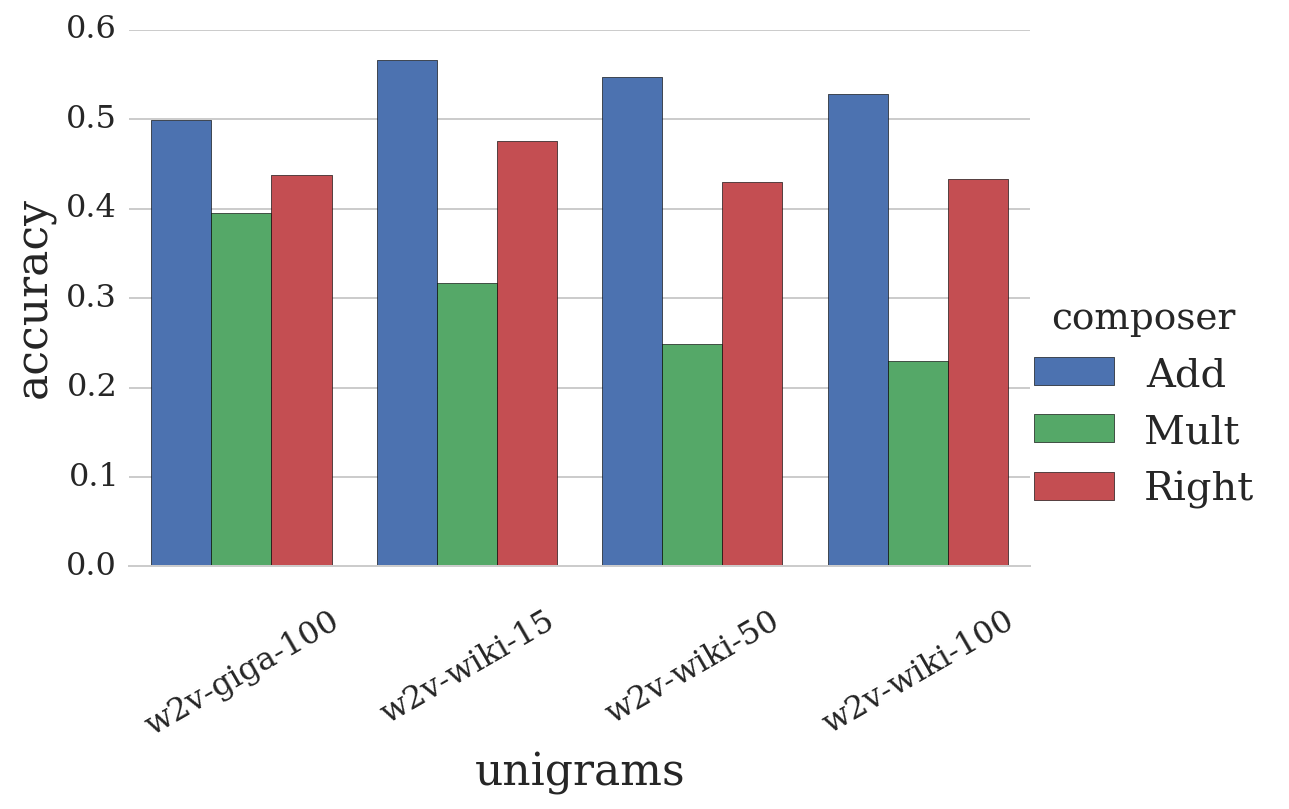

In [8]:
# reported accuracies: Add=50%, Mult=57%, SOTA=81.6 (Turney holistic model)
df_res = pd.DataFrame(results, columns=['unigrams', 'composer', 'coverage', 'accuracy'])
g = sns.factorplot(data=df_res, x='unigrams', hue='composer', y='accuracy', kind='bar', x_order=names, aspect=1.5)
g.set_xticklabels(rotation=30);
sns.despine(left=True)
plt.savefig('plot-intrinsic-turney.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

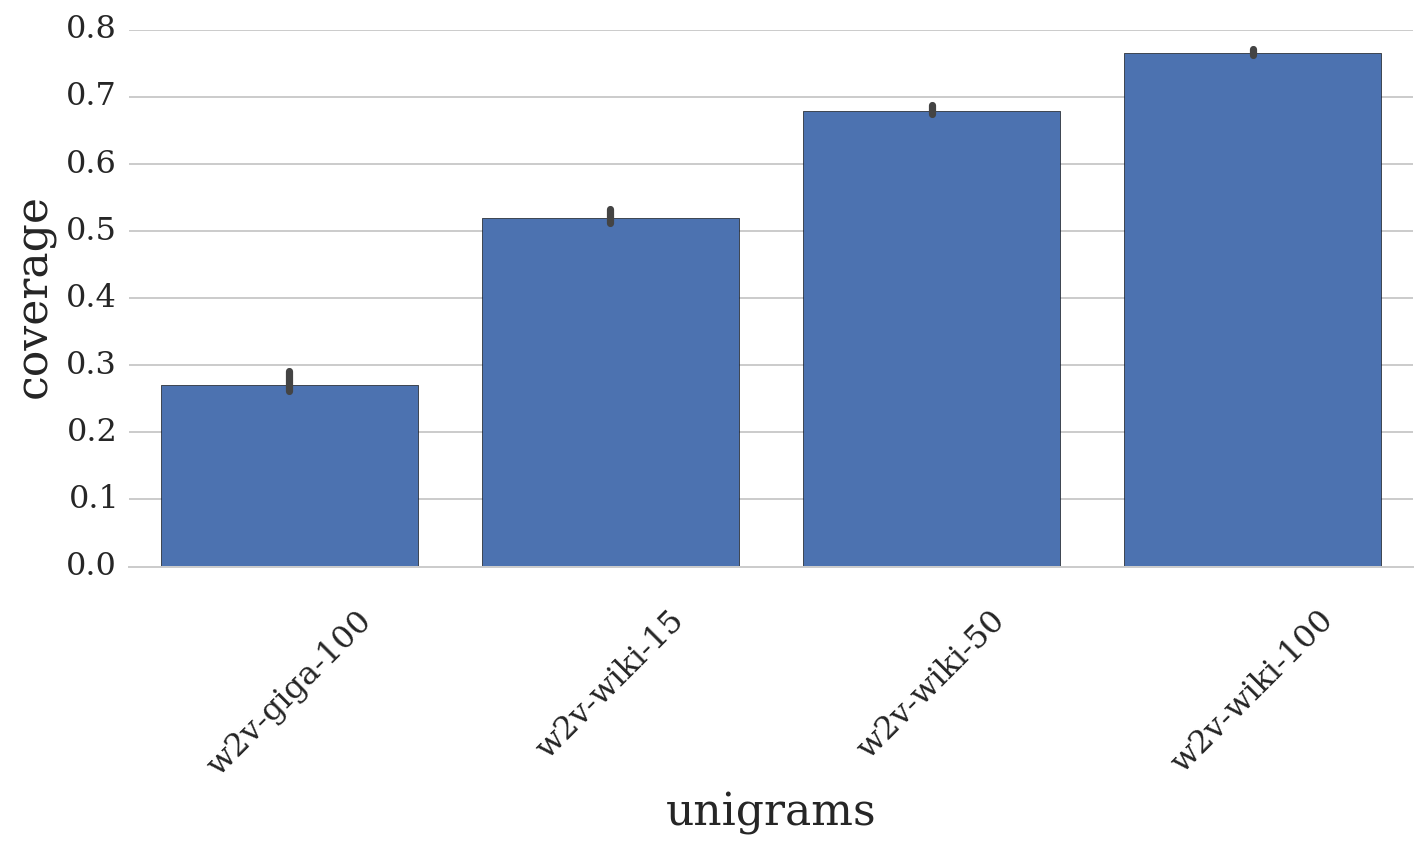

In [7]:
g = sns.factorplot(data=df_res, x='unigrams', y='coverage', kind='bar', x_order=names, aspect=2)
g.set_xticklabels(rotation=45);
sns.despine(left=True)
plt.savefig('plot-intrinsic-turney-coverage.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [64]:
test_phrase = 'bass fiddle'
unigram_source = vv.from_tsv(paths[0])
composer = AdditiveComposer(unigram_source)
pred, scores = predict(test_phrase, list(df.ix[test_phrase].values), composer, unigram_source)
gold = df.ix[test_phrase, 0]
pred, gold, scores

('violin',
 'contrabass',
 defaultdict(<function _maxint at 0x10ad91048>, {'speedway': 3.8477224206890175, 'violin': 2.5607110699209996, 'pitch': 3.017607573653578}))

# Observations
 - need to count how many times we don't have a vector for the gold unigram- if we don't, we can't return it as a neighbour
  - without it, models attempt >95% of questions; with it only 30%-75%
 - closest neighbour may be one with a stupid PoS tag- infrequent words may have shorter vectors and come up closer as neighbour. Solutions:
  - use cosine sim: not sompatible with the rest of experiments
  - normalise vectors by length
  - prefer J to N to V???

Task is set up to test if models are skating by on lexical overlap. I am not disallowing it here as it would be slightly unfair, but then the results of this test will not be compatible with my DC results. Should do both versions.

See §4.2 in (Turney, 2012), esp. eq 30/31, table 15 for explanation of how he does the evaluation